# Amazon Polarity Dataset Processing
This work is focused on processing a sub-set of the Amazon Polarity Dataset. The task proposed by the creators of the dataset is to classify reviews into positive or negative. So each sample has a title, text, and label ($1$ for a negative review, $2$ for a positive review). We will focus more concretely on unsupervised methods to treat the data (LDA initially). The dataset is available [here](https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz).

In [1]:
# Imports.
import numpy  as np
import pandas as pd
from string import punctuation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data Loading and pre-processing

In [2]:
# Global variables.
DATASET_PATH = '../Datasets/amazon_review_polarity_csv/'

# Load dataset using the datasets library. We will load only 5000 raws at each time.
df_train_iterator = pd.read_csv(DATASET_PATH + 'train.csv', names=["score", "title", "text"], chunksize=5000)

In [3]:
# Get the first chunk of data for our work.
df = next(df_train_iterator)
df.head()

,score,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [4]:
# Pre-processing function.
def remove_punct_lower(text):
    n_text = text.replace('\n','. ').split(". ")
    return ''.join([c for c in n_text if c not in punctuation]).lower()

In [5]:
df_train = df[0:5000].copy()
df_train['text'] = df_train['text'].apply(remove_punct_lower)
df_train['title'] = df_train['title'].apply(remove_punct_lower)
df_train.head()

,score,title,text
0,2,stuning even for the non-gamer,this sound track was beautiful! it paints the ...
1,2,the best soundtrack ever to anything.,i'm reading a lot of reviews saying that this ...
2,2,amazing!,this soundtrack is my favorite music of all ti...
3,2,excellent soundtrack,i truly like this soundtrack and i enjoy video...
4,2,"remember, pull your jaw off the floor after he...","if you've played the game, you know how divine..."


We will only use this batch composed of $5000$ samples in this notebook.

## 2. LDA Approach
Once the dataset is set it is time to have fun. First, we define a set of helper functions. Then we apply the model. A brief exploratory analysis of the dataset is also presented in a form of wordcloud, just to visualize the most common words in the dataset.

In [6]:
# Check if there is some duplicate in a list.
def there_is_duplicate_in_list(my_list):
    '''
    Inputs:
        - my_list: list of elements.
    '''
    my_set = set(my_list) # Convert list to a set so that any duplicate elements are removed.
    return len(my_list) != len(my_set)

# Print the topic of a single sentence.
def print_topic_for_sample(model, sample):
    '''
    Inputs:
        - model: LDA model previously fit with data.
        - sample: vectorized string.
    '''
    topic_idx = np.argmax(model.transform(sample)) + 1
    return topic_idx

# Print topics discovered by LDA.
def print_topics(model, count_vectorizer, n_top_words):
    '''
    Inputs:
        - model: LDA model previously fit with data.
        - count_vectorizer: SKLearn CountVectorizer for English stop words.
        - n_top_words: integer defining the number of words to show per topic.
    '''
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx + 1))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

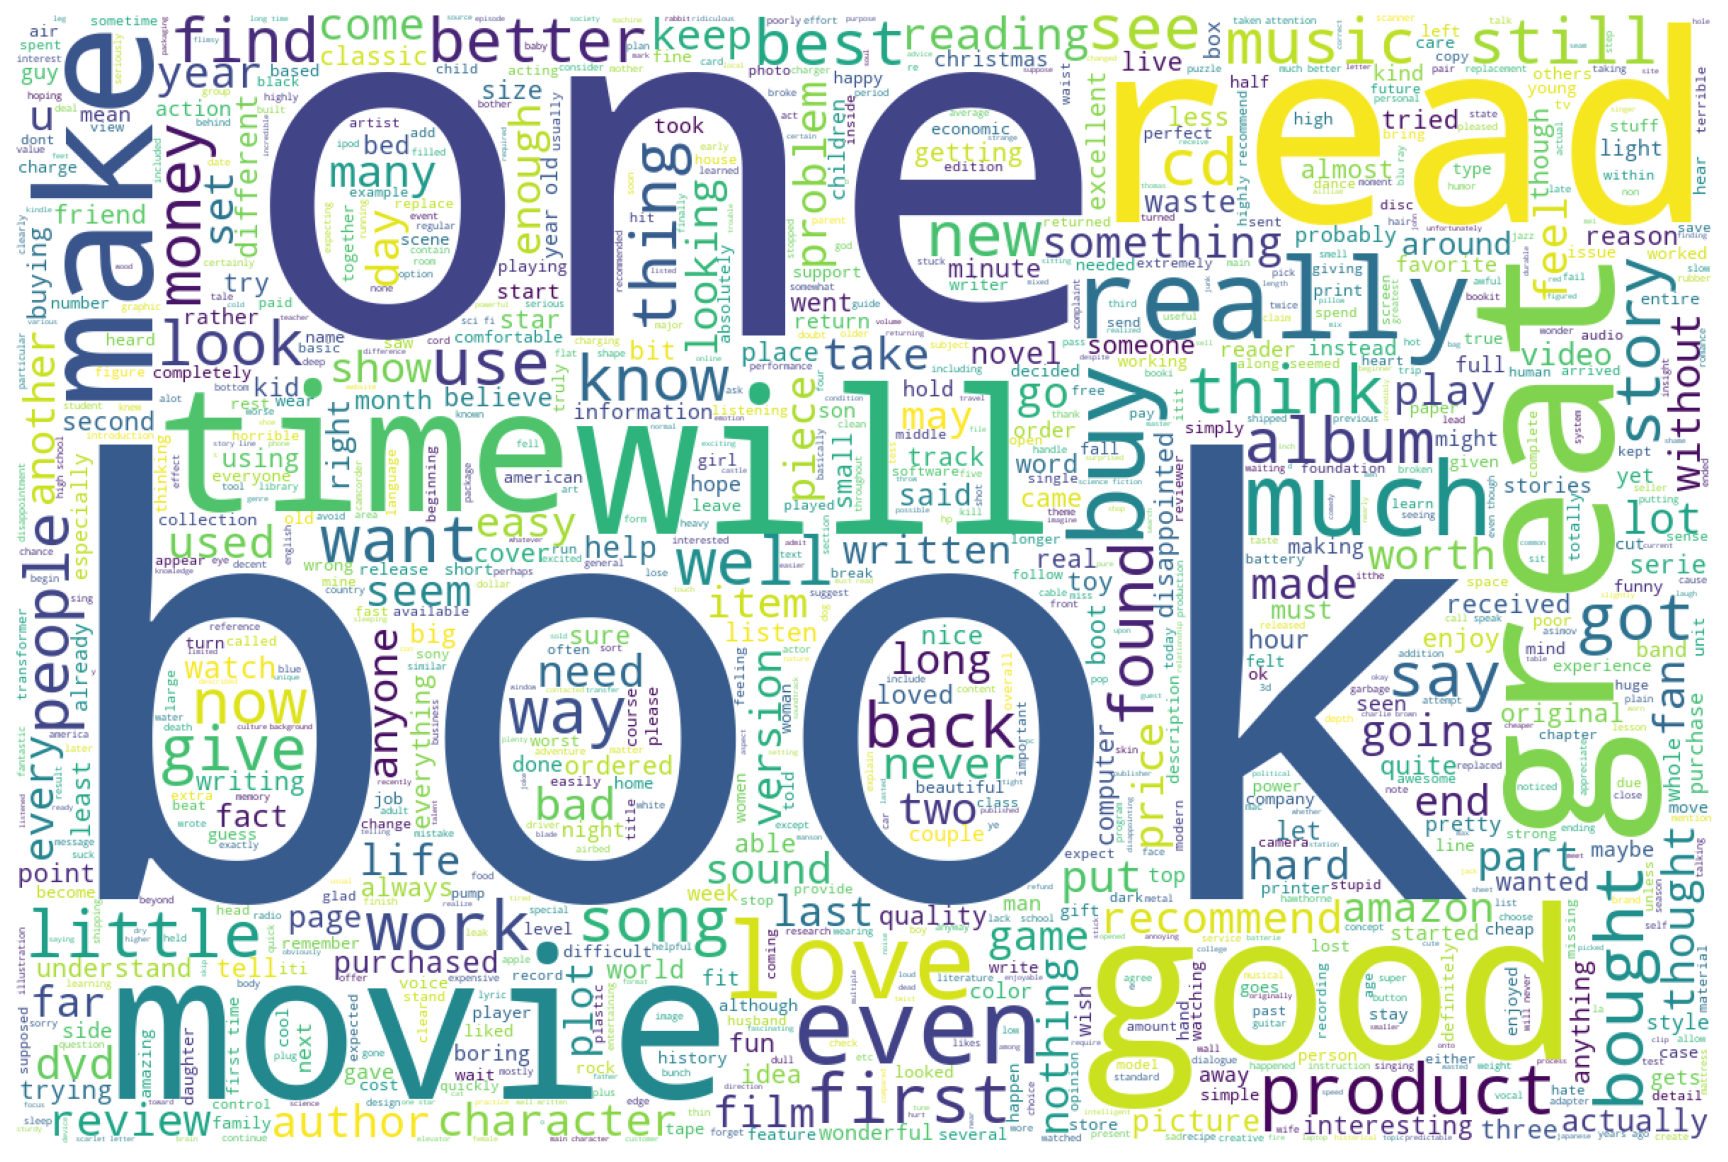

In [7]:
# WordCloud generator for exploratory analysis.
def generate_wordcloud(text_list, filename=None):
    '''
    Inputs:
        - text_list: list of strings to generate the word cloud.
        - filename: name of the file to save the figure.
    '''
    long_string = ' '.join(text_list)
    wordcloud = WordCloud(background_color="white", 
                          max_words=1000, 
                          contour_width=3, 
                          contour_color='steelblue', 
                          width=1200, 
                          height=800)
    wordcloud.generate(long_string)
    fig, ax = plt.subplots(figsize=(20,10), dpi=150)
    ax.axis("off")
    if filename:
        wordcloud.to_file(filename) # You would use this to save the cloud into a file
    else:
        plt.imshow(wordcloud)
    
# Generate the wordcloud using our function
generate_wordcloud(text_list=df_train['text'])

Most reviews from the first batch of the train set are referring to <code>books</code>, apparently.

In [8]:
# ------------------ Extract Features ------------------ #
# Initialise count vectorizer with the English stop words.
count_vectorizer = CountVectorizer(stop_words='english')

# Get train features.
X_train = count_vectorizer.fit_transform(df_train['text'])

# ------------------ Train LDA Model ------------------ #
number_topics = 2 # Two classes, so we set one topic per class (hoping that it will split topics this way).
random_state_val = 1

model = LDA(n_components=number_topics, random_state=random_state_val)
fitted = model.fit_transform(X_train)

In [9]:
number_words = 20 # This is only for visualization.
print_topics(model, count_vectorizer, number_words)


Topic #1:
just product like buy bought time great use good got don really movie used does money did work new little

Topic #2:
book read like good just great movie really time story love books cd don music album reading best people know


Note that we already obtained a predicted "label" for each document (review) of our dataset: the probabilities 
of the document to belong to one topic or another. For instance, the probabilities to belong to topics 1 and 2,
respectively, for the i-th document are shown next:

In [10]:
i_doc = 0
prob_topic_1 = fitted[i_doc][0]
prob_topic_2 = fitted[i_doc][1]
print(f"For the {i_doc}-th document:")
print(f"Probability to belong to topic 1: {prob_topic_1}")
print(f"Probability to belong to topic 2: {prob_topic_2}")

For the 0-th document:
Probability to belong to topic 1: 0.01702130883797061
Probability to belong to topic 2: 0.9829786911620293


In [11]:
# Compare predicted labels with real labels.
from sklearn.metrics import classification_report
y_true = df_train["score"].apply(lambda x: 0 if x==1 else 1).to_list() # Convert labels to [0,1].
y_pred = np.argmax(fitted, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.50      0.55      2692
           1       0.52      0.63      0.57      2308

    accuracy                           0.56      5000
   macro avg       0.56      0.56      0.56      5000
weighted avg       0.57      0.56      0.56      5000



Given that we applied a fully unsupervised method to classify the reviews, we were able to get a $56\%$ of accuracy, which is already better than tossing a coin. Considering that there is a support of $49.28\%$ (class $0$) vs $50.72\%$ (class $1$). Note also that these results depend on the <code>random_state</code> parameter to train the LDA model. 